In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


# Global FNR

In [4]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fnr = sage.PermutationEstimator(imputer, 'fnr')
%time sage_values_fnr = estimator_fnr(test, Y_test, n_permutations=10000)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

Printing iterative loss to prev_loss_1642094470.647362.txt
CPU times: user 8min 21s, sys: 6.2 s, total: 8min 27s
Wall time: 7min 56s
SAGE values using false negative rate as loss: SAGE Explanation(
  (Mean): [-0.00 -0.00 -0.00 ... -0.00 -0.00 -0.00]
  (Std):  [3.95e-05 3.97e-05 3.93e-05 ... 3.92e-05 3.88e-05 3.88e-05]
)


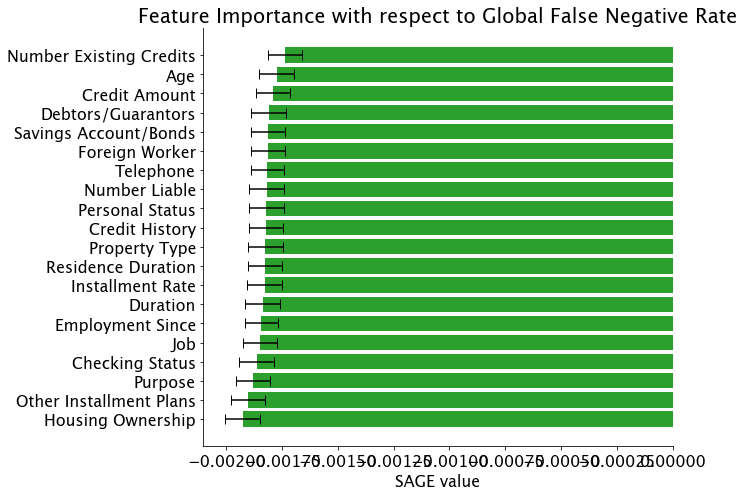

In [5]:
sage_values_fnr.plot(feature_names, title='Feature Importance with respect to Global False Negative Rate')

# Young group FNR

In [6]:
age_col = feature_names.index("Age")

In [7]:
young = test[:,age_col] <= 30

test_young = test[young]
Y_test_young = Y_test[young]

In [8]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[:512])
estimator_young_fnr = sage.PermutationEstimator(imputer_young, 'fnr')
%time sage_values_young_fnr = estimator_young_fnr(test_young, Y_test_young, n_permutations=10000)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_young_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

Printing iterative loss to prev_loss_1642094947.5079849.txt
CPU times: user 8min 2s, sys: 4.63 s, total: 8min 7s
Wall time: 7min 32s
SAGE values using false negative rate as loss: SAGE Explanation(
  (Mean): [-2.51e-05  1.19e-05 -1.25e-05 ... -3.33e-06  2.30e-05  4.99e-05]
  (Std):  [3.07e-05 3.03e-05 3.00e-05 ... 3.08e-05 3.13e-05 3.02e-05]
)


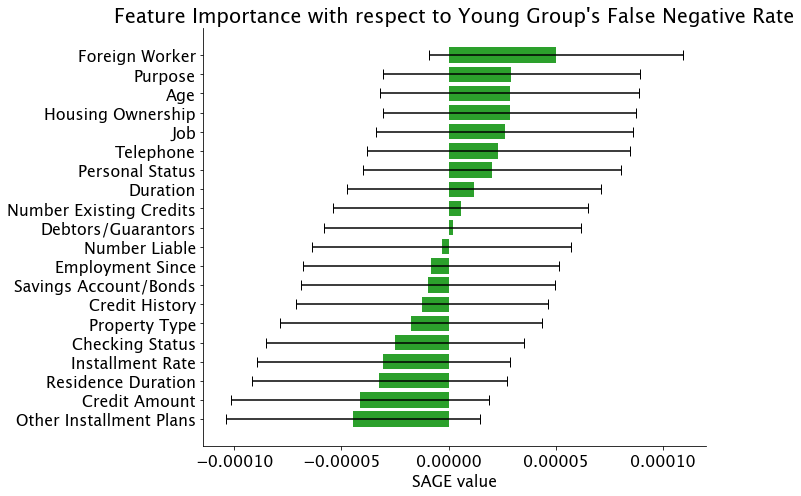

In [9]:
sage_values_young_fnr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Negative Rate')

# Old group FNR

In [10]:
old = np.invert(young)

test_old = test[old]
Y_test_old = Y_test[old]

In [11]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[:512])
estimator_old_fnr = sage.PermutationEstimator(imputer_old, 'fnr')
%time sage_values_old_fnr = estimator_old_fnr(test_old, Y_test_old, n_permutations=10000)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_old_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

Printing iterative loss to prev_loss_1642095400.135218.txt
CPU times: user 13min 28s, sys: 13.5 s, total: 13min 42s
Wall time: 5h 14min 3s
SAGE values using false negative rate as loss: SAGE Explanation(
  (Mean): [-0.00 -0.00 -0.00 ... -0.00 -0.00 -0.00]
  (Std):  [4.60e-05 4.70e-05 4.65e-05 ... 4.60e-05 4.58e-05 4.61e-05]
)


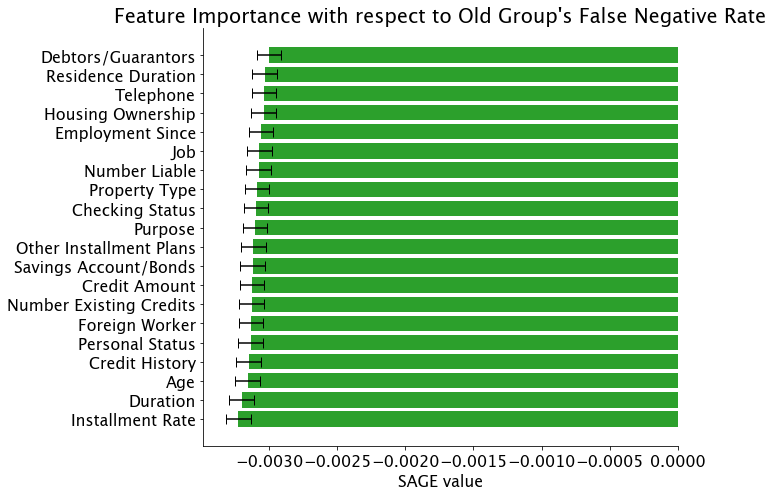

In [12]:
sage_values_old_fnr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Negative Rate')